## Introduction 

Hello! This is the first data science project I will be conducting, outside of any academic or professional environment, for the purposes of uploading for public view. I had originally considered a finance-based dataset, but stumbled upon this (at the time)fresh dataset on Kaggle that contained both qualitative and quantitative data, and more importantly, centred around a field that I have a personal interest in: films. 

The intended goal of this notebook, from a personal and professional development standpoint, is to display the application of certain data science related concepts that I have been learning primarily through my postgraduate program at the University of the West Indies, Mona, and secondarily through independent study using online resources. In terms of business applications, this project aims to classify certain films based on variables such as runtime, and genre, to recommend to cinema operations staff those films that may provide the greatest revenue.

This dataset may be downloaded at: https://www.kaggle.com/preetviradiya/imdb-movies-ratings-details.

## Data Dictionary

| Field | Details |
|  ---  |   ---   |
| name  | The title of the film |
| year  | The year the film was released |
| runtime | The duration of the film in minutes |
| genre | The genre of the film |
| rating | The score of the film from 0 - 10 based on votes by imdb users |
| metascore | The score of the film from 0 - 10 based on data from metacritic.com |
| timeline | A short summary of the events of the film |
| votes | The number of imdb users that have rated the film |
| gross | The box office revenue for that film |


In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
sns.set_theme(style='whitegrid')

In [3]:
df = pd.read_csv('IMDB_movie_reviews_details.csv')

## Data Preparation

In [4]:
# View a list of the fields/columns in the dataset
print('The field names are', ", ".join([str(i) for i in df.columns.to_list()]), '.')
print('The size of the dataframe is', len(df), 'records.')

The field names are Unnamed: 0, name, year, runtime, genre, rating, metascore, timeline, votes, gross .
The size of the dataframe is 1000 records.


In [5]:
# Check for null values
df.isnull().sum()

Unnamed: 0      0
name            0
year            0
runtime         0
genre           0
rating          0
metascore     159
timeline        0
votes           0
gross         171
dtype: int64

We notice that the metascore field has 159 missing entries. Similarly, the gross field has 171 missing entries. Let us make a note of this to consider later.

In [6]:
# The dataset has relatively few columns, so we can call the head method to view the top 5 records
df.head()

Unnamed: 0                      name  year  runtime                 genre  \
0           0  The Shawshank Redemption  1994      142                 Drama   
1           1             The Godfather  1972      175          Crime, Drama   
2           2           Soorarai Pottru  2020      153                 Drama   
3           3           The Dark Knight  2008      152  Action, Crime, Drama   
4           4    The Godfather: Part II  1974      202          Crime, Drama   

   rating  metascore                                           timeline  \
0     9.3       80.0  Two imprisoned men bond over a number of years...   
1     9.2      100.0  An organized crime dynasty's aging patriarch t...   
2     9.1        NaN  Nedumaaran Rajangam "Maara" sets out to make t...   
3     9.0       84.0  When the menace known as the Joker wreaks havo...   
4     9.0       90.0  The early life and career of Vito Corleone in ...   

       votes     gross  
0  2,394,059   $28.34M  
1  1,658,439  $134.97M  
2     78,266       NaN  
3  2,355,907  $534.86M  
4  1,152,912   $57.30M

The Unnamed: 0 field corresponds to the ID number of the film in the original dataset, and is equivalent to the index of the film in the dataframe. This field is both irrelevant, and superfluous, so we can go ahead and drop it.

In [7]:
df.drop(columns='Unnamed: 0', inplace=True)

Let us take a look at the data types

In [8]:
df.dtypes

name          object
year          object
runtime        int64
genre         object
rating       float64
metascore    float64
timeline      object
votes         object
gross         object
dtype: object

We need to convert year, votes, and gross to numeric data types for further analysis. Year must be a 4 digit integer. Let us check if there are any values for year that do not fit this constraint.

In [9]:
df.loc[df.year.str.len() != 4].year.value_counts()

I 2015      4
I 2014      3
I 2017      3
I 2004      3
II 2015     2
II 2016     2
I 2011      2
I 2013      2
I 2007      2
I 2010      2
I 2016      1
III 2016    1
I 2008      1
I 2020      1
I 2001      1
I 1995      1
I 1985      1
III 2018    1
Name: year, dtype: int64

We have a few items that include letters in their year value. Let us proceed by removing all alphabetical characters from values in the year field.

In [10]:
df.year = df.year.str.replace(r'\D+', '', regex=True)
# Let us check to see if this was performed correctly
print('The number of non 4 digit integers is', len(df.loc[df.year.str.len() != 4].year))

The number of non 4 digit integers is 0


In [11]:
# Convert to int
df.year = pd.to_numeric(df.year)

Let us repeat this step for the other numerical fields: votes and gross.

In [12]:
df.votes = df.votes.str.replace(r'\D+', '', regex=True)
df.votes = pd.to_numeric(df.votes)

We can plot a box plot of df.votes to visualize the range of values.

<AxesSubplot:xlabel='votes'>

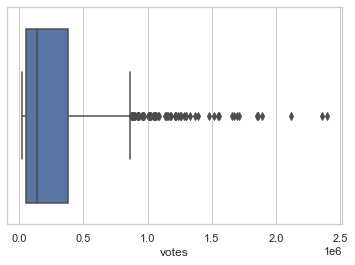

In [13]:
sns.boxplot(x=df.votes)

In [14]:
df.gross

0       $28.34M
1      $134.97M
2           NaN
3      $534.86M
4       $57.30M
         ...   
995         NaN
996         NaN
997     $20.00M
998     $30.50M
999         NaN
Name: gross, Length: 1000, dtype: object

For gross, we need to consider that the values are expressed in terms of millions. The characters that follow the decimal point represent fractions of a millions unit. Accordingly, we can choose to either retain the decimal values, and keep this in mind when performing statistical analysis, or to convert the value to regular integers now. Let us go with the second option.

In [15]:
def gross_conversion(value):
    """
    Removes all non-numeric characters from value except '.', then multiplies the resulting value by 
    1000000.
    """
    try:
        return float(re.sub(r'[^\d.]+', '', str(value)))*1000000
    except:
        value = np.nan

# Apply function to values in df.gross
df['gross'] = df.gross.apply(gross_conversion)

We can check to see if this operation was performed successfully by plotting a boxplot of df.gross.

<AxesSubplot:xlabel='gross'>

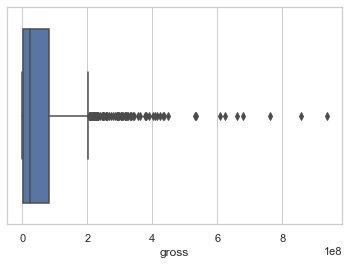

In [16]:
sns.boxplot(x=df.gross)

In [17]:
# Let us confirm the new data types
df.dtypes

name          object
year           int64
runtime        int64
genre         object
rating       float64
metascore    float64
timeline      object
votes          int64
gross        float64
dtype: object

Let us now take a look at the genre field in more detail.

In [18]:
df.genre

0                       Drama
1                Crime, Drama
2                       Drama
3        Action, Crime, Drama
4                Crime, Drama
                ...          
995    Comedy, Drama, Romance
996            Drama, Western
997            Drama, Western
998       Drama, Romance, War
999                Drama, War
Name: genre, Length: 1000, dtype: object

We can see that a record can have multiple genres associated with it, entered as comma separated values. 

## Exploratory Analysis

Let us look at some summary statistics of the numeric fields. 

In [19]:
df.describe()

year      runtime       rating   metascore         votes  \
count  1000.000000  1000.000000  1000.000000  841.000000  1.000000e+03   
mean   1991.238000   123.017000     7.954000   78.158145  2.790882e+05   
std      23.403014    28.212598     0.276008   12.289270  3.343180e+05   
min    1920.000000    45.000000     7.600000   28.000000  2.511600e+04   
25%    1976.000000   103.000000     7.700000   71.000000  5.577425e+04   
50%    1999.000000   119.000000     7.900000   79.000000  1.415310e+05   
75%    2010.000000   137.000000     8.100000   87.000000  3.809945e+05   
max    2021.000000   321.000000     9.300000  100.000000  2.394059e+06   

              gross  
count  8.290000e+02  
mean   6.815333e+07  
std    1.099501e+08  
min    0.000000e+00  
25%    3.200000e+06  
50%    2.309000e+07  
75%    8.301000e+07  
max    9.366600e+08

The most important points here are that there are 159 records with missing metascores, and that the film with the lowest number of IMDb votes still registered around 25,000 votes, which is fairly large enough to avoid extremist opinions. There also appears to be a movie that generated no revenue at the box office.

Let us take a look at the relationship between the variables.

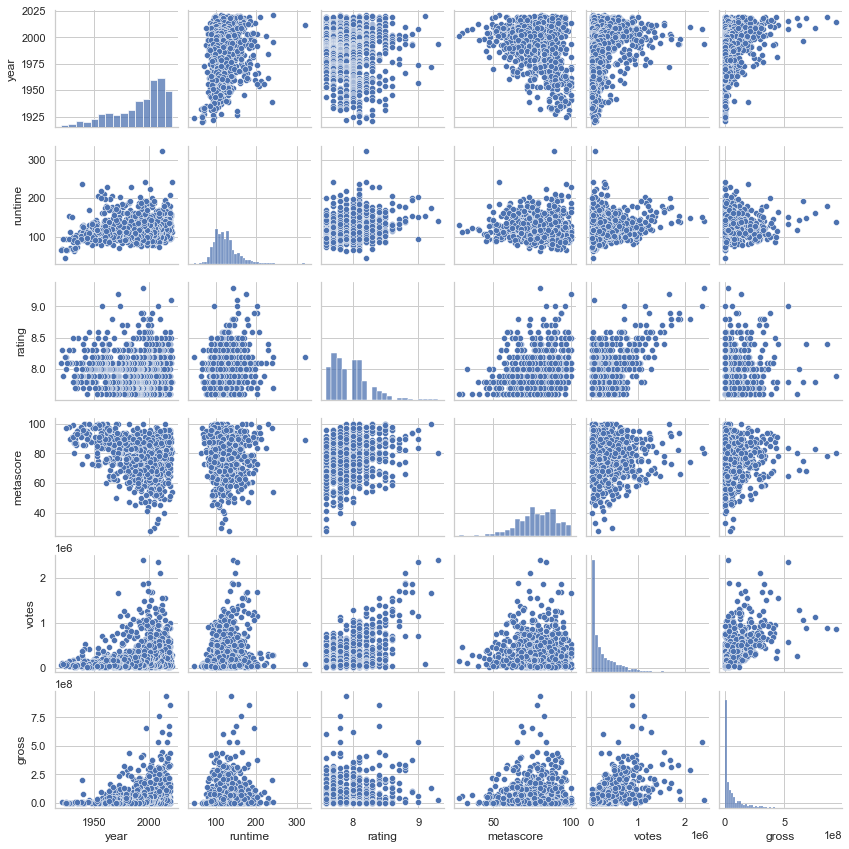

In [20]:
sns.pairplot(df, height=2)

<AxesSubplot:>

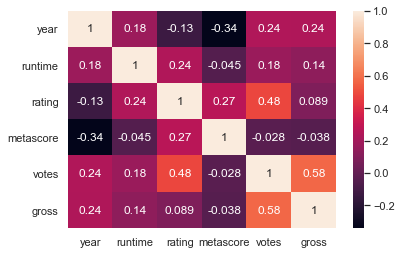

In [21]:
sns.heatmap(df.corr(), annot=True)

Our target variable is gross (revenues). From the heatmap above, we can see that the only variable that possesses a strong relationship with gross revenue is the number of IMDb votes a movie has, with a correlation coefficient of 0.58, indicating a fairly strong positive relationship. This can be explained by IMDb votes being a proxy for popularity; the more popular a movie, the more revenue it tends to gross. We can also see that the later the year of release, the more revenue the film tended to gross. Attempts to explain this particular relationship are outside the scope of this project; considerations include whether the reported revenue figures are adjusted for inflation, the growth of the film industry between 1920 and 2021, the growth of the economy between this period, etc. 

Let us check for null values

In [22]:
df.isnull().sum()

name           0
year           0
runtime        0
genre          0
rating         0
metascore    159
timeline       0
votes          0
gross        171
dtype: int64

We see that there are 159 missing metascore values, and 171 missing gross (revenue) values. Because these figures are fairly large, I would prefer not to drop the records completely. Let us fill them with the median values for those fields. Note: this is a temporary solution; will be revised.

In [23]:
df.metascore.fillna(df.metascore.median(), inplace=True)
df.gross.fillna(df.gross.median(), inplace=True)

## Regression Model

We can now build our multivariate linear regression model. We must first prepare the data to be divided into training, and test sets.

In [24]:
# Create dataframe object of independent variables only
X = df[['year', 'runtime', 'rating', 'metascore', 'votes']]
# Create dataframe object of dependent variable only
Y = df['gross']

In [25]:
X.head()

year  runtime  rating  metascore    votes
0  1994      142     9.3       80.0  2394059
1  1972      175     9.2      100.0  1658439
2  2020      153     9.1       79.0    78266
3  2008      152     9.0       84.0  2355907
4  1974      202     9.0       90.0  1152912

In [26]:
Y.head()

0     28340000.0
1    134970000.0
2     23090000.0
3    534860000.0
4     57300000.0
Name: gross, dtype: float64

In [27]:
# Split the data into training, and test sets using a 3:7 ratio of test to training data
x_train, x_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=0.3,
    random_state=42
)

In [28]:
# Create LinearRegresion class object
regressor = linear_model.LinearRegression()
# Fit x_train and y_train
regressor.fit(x_train, y_train)

LinearRegression()

In [29]:
# Pass the x_test variable to test our model
y_pred = regressor.predict(x_test)

Construct a dataframe to compare our current model's predicted gross revenue against the actual gross revenue reported.

In [30]:
pred_vs_actual = pd.DataFrame({
    'Predicted Gross': y_pred,
    'Actual Gross': y_test
})
pred_vs_actual['Error'] = pred_vs_actual['Predicted Gross']-pred_vs_actual['Actual Gross']

In [31]:
pred_vs_actual

Predicted Gross  Actual Gross         Error
521     1.017564e+08    35550000.0  6.620636e+07
737     4.285519e+07     1330000.0  4.152519e+07
740     6.579243e+07   434040000.0 -3.682476e+08
660     6.419114e+07    12340000.0  5.185114e+07
411     1.624028e+07    27550000.0 -1.130972e+07
..               ...           ...           ...
468    -6.470440e+06    23090000.0 -2.956044e+07
935     2.573837e+07       10000.0  2.572837e+07
428     7.215361e+07   232910000.0 -1.607564e+08
7       3.052270e+08   107930000.0  1.972970e+08
155     1.306173e+08   415000000.0 -2.843827e+08

[300 rows x 3 columns]

<AxesSubplot:xlabel='Predicted Gross', ylabel='Actual Gross'>

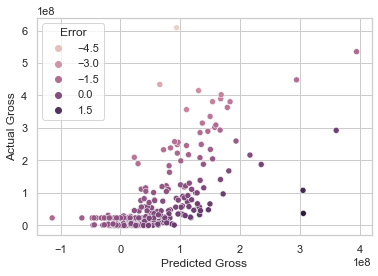

In [32]:
sns.scatterplot(
    data=pred_vs_actual,
    x='Predicted Gross',
    y='Actual Gross',
    hue='Error',
)

We can take a look at the regression coefficients for each of the independent variables.

In [33]:
coefs = {
    'Features': X.columns, 
    'Coefficient': regressor.coef_
}
coefs_df = pd.DataFrame(coefs)
coefs_df

Features   Coefficient
0       year -3.083503e+04
1    runtime  4.223086e+05
2     rating -1.221686e+08
3  metascore  4.168055e+05
4      votes  2.171348e+02

In [34]:
regressor.score(x_test, y_test)

0.43720580990247004